In [6]:
#!pip install casadi
#!pip install do_mpc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.2 MB/s eta 0:00:00ta 0:00:01


In [39]:
# importando as bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import do_mpc as dmpc
from casadi import *

In [40]:
# Criando o modelo

tipo_modelo = 'continuous' # Define se é discreto 'discrete' or continuo 'continuos'
modelo = dmpc.model.Model(tipo_modelo)

In [41]:
# Parâmetros

m = 1.0 # kg, massa do carro
m1 = 0.4  # kg, massa do pêndulo inferiror
m2 = 0.4  # kg, massa do pêndulo superiror

L1 = 0.5 # m, comprimento do pêndulo inferior 
L2 = 0.5 # m, comprimento do pêndulo superior

g = 9.81 # m/s^2 , aceleração da gravidade   

l1 = L1/2 # m,
l2 = L2/2 # m,
J1 = (m1 * l1**2) / 3   # Inercia
J2 = (m2 * l2**2) / 3   # Inercia
f0 = 0.01
f1 = 0.007
f2 = 0.007

a1 = m+m1+m2
a2 = l1*(m1+2*m2)
a3 = m2*l2

b2 = m1*l1**2 +J1+2*m2*l1**2
b3 = 2*m2*l1*l2

c3 = 2*m2*l2*l2+J2


d3 = m2*g*l2 

In [42]:
pos = modelo.set_variable('_x',  'pos')
phi = modelo.set_variable('_x',  'phi', (2,1))
dpos = modelo.set_variable('_x',  'dpos')
dphi = modelo.set_variable('_x',  'dphi', (2,1))

u = modelo.set_variable('_u',  'force')

In [43]:
ddpos = modelo.set_variable('_z', 'ddpos')
ddphi = modelo.set_variable('_z', 'ddphi', (2,1))

In [44]:
modelo.set_rhs('pos', dpos)
modelo.set_rhs('phi', dphi)
modelo.set_rhs('dpos', ddpos)
modelo.set_rhs('dphi', ddphi)

In [45]:
euler_lagrange = vertcat(
        # 1
        a1*ddpos - ddphi[0]*a2*cos(phi[0]) - a3*ddphi[1]*cos(phi[1]) + dphi[0]**2*a2*sin(phi[0]) + a3*phi[1]**2*sin(phi[1]) +f0*dpos - u,
        # 2
        -ddpos*cos([0])*a2 + ddphi[0]*b2 + a3*ddphi[1]*cos(phi[0]-phi[1]) + (f1+f2)*dphi[0] - dphi[1]*(b3*sin(phi[1]-phi[0])-f2) - g*a2*sin(phi[0]),
        # 3
        -ddpos*a3*cos(phi[1]) + b3*ddphi[0]*cos(phi[0]-phi[1]) + ddphi[1]*c3 - dphi[0]*(f2+b3*dphi[0]*sin(phi[1]-phi[0]))+f2*dphi[1] - d3*sin(phi[1])
    )

modelo.set_alg('euler_lagrange', euler_lagrange)

In [46]:
E_kin_cart = 1 / 2 * m * dpos**2

E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dphi[0] * cos(phi[0]))**2 +
    (l1 * dphi[0] * sin(phi[0]))**2) + 1 / 2 * J1 * dphi[0]**2

E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dphi[0] * cos(phi[0]) + l2 * dphi[1] * cos(phi[1]))**2 +
    (L1 * dphi[0] * sin(phi[0]) + l2 * dphi[1] * sin(phi[1]))**
    2) + 1 / 2 * J2 * dphi[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
phi[0]) + m2 * g * (L1 * cos(phi[0]) +
                            l2 * cos(phi[1]))

modelo.set_expression('E_kin', E_kin)
modelo.set_expression('E_pot', E_pot)

SX(((0.981*cos(phi_0))+(3.924*((0.5*cos(phi_0))+(0.25*cos(phi_1))))))

In [47]:
# Build the model
modelo.setup()

In [49]:
mpc = dmpc.controller.MPC(modelo)

In [50]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [51]:
mterm = modelo.aux['E_kin'] - modelo.aux['E_pot'] # terminal cost
lterm = modelo.aux['E_kin'] - modelo.aux['E_pot'] # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.1)

In [52]:
mpc.bounds['lower','_u','force'] = -4
mpc.bounds['upper','_u','force'] = 4

In [53]:
mpc.setup()

In [55]:
estimator = dmpc.estimator.StateFeedback(modelo)

In [56]:
simulator = dmpc.simulator.Simulator(modelo)

In [57]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [58]:
simulator.setup()

In [84]:
simulator.x0['phi'] = 2*np.pi/2

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [85]:
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [86]:
mpc_graphics = dmpc.graphics.Graphics(mpc.data)

In [87]:
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([
        x[0],
        x[0]+L1*np.sin(x[1])
    ])

    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])

    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])

    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])

    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))

    return line_1, line_2

In [88]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='phi', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

In [89]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    20206
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6114

Total number of variables............................:     4330
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4206
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9632400e+02 5.18e-05 4.98e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

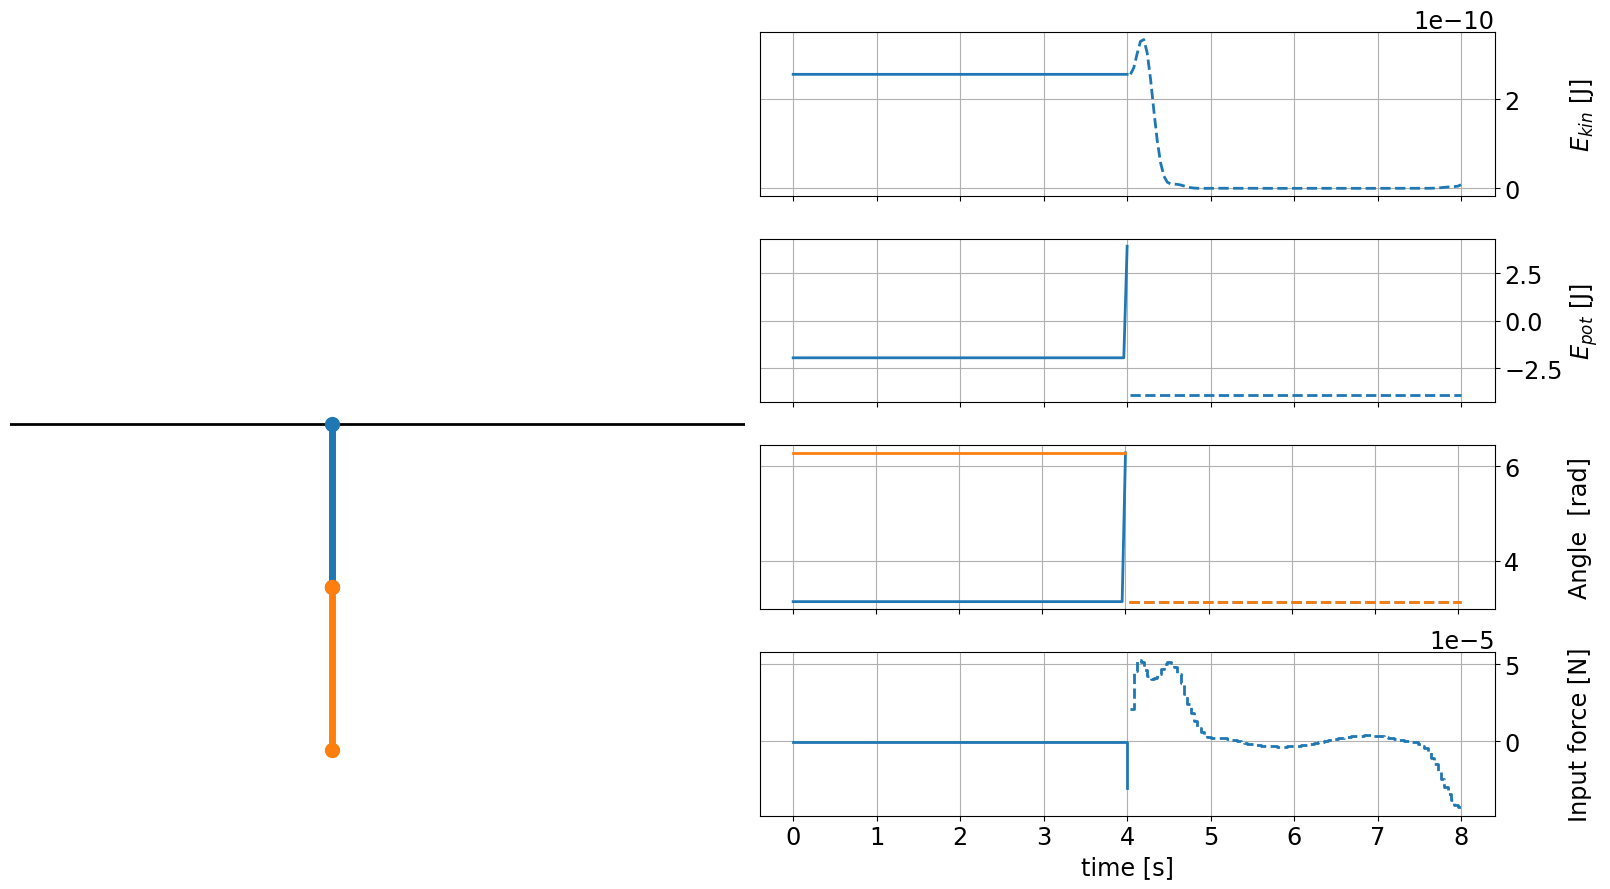

In [90]:
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [91]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=60)
anim.save('/tmp/anim_dip.gif', writer=gif_writer)

ExecutableNotFoundError: [Errno 2] No such file or directory: 'convert'

Bad pipe message: %s [b'ation/xhtml+xml, application/xml; q=0.9, image/avif, image/webp, image/apng, */*; q=0.8\r\nHost: localhost', b'5815\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x6']
Bad pipe message: %s [b' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.', b'0.0 Safari/537.36\r\nAccept-Encoding: gzip, defla']
Bad pipe message: %s [b', br, zstd\r\nAccept-Language: pt-BR, pt; q=0.7\r\nCache-Control: max-age=0\r\nReferer: https://opulent-trout-x46j5p6wj7g', b'q67-45815.app.github.dev/?vscodeBrowserReqId=1711047590001\r\nX-Request-ID: 382d33cfe0f9d83e9056f972']
Bad pipe message: %s [b'f2086c\r\nX-Real-IP: 10.240.3.196\r\nX-Forwarded-Proto: http', b'\nX-Forwarded-Host: opulent-trout-x46j5p6wj7gc6q67-45815.app.github.dev\r\nX-Forwarded-Port: 443\r\nX-Forwarded-Scheme:', b'ttps\r\nX-Original-URI: /?vscodeB']
Bad pipe message: %s [b'wserReqId=1711047590001\r\nX-Scheme: https\r\nProxy-Connection: Keep-Alive\r\nsec-ch-ua: "Brave";v="123", "Not:A-Brand"', b'="8", "Chromium";v="1

In [76]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
anim.save('anim_dip.gif', writer=gif_writer)

ExecutableNotFoundError: [Errno 2] No such file or directory: 'convert'